# Mapping Allen institute scRNA-seq reference to Visium spatial (mouse brain)

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#read_visium)
* [Loading Allen single cell reference data](#read_allen)


* [cell2location analysis](#cell2location)
* [Loading cell2location results](#cell2location_res)
* [Evaluate mapping accuracy by comparing to Allen](#mapping_accuracy)


* [Fig 2J](#Fig2J)
* [Fig 2J supplementary spatial maps](#suppl_spatial_maps)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import scipy.sparse as ss
import h5py
import matplotlib
data_type = 'float32'

# this line should go before importing pycell2location
#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
from cell2location.plt.plot_heatmap import clustermap

from matplotlib import rcParams
import seaborn as sns
import glob

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Loading Visium data <a class="anchor" id="read_visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/'
sp_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/allen_negative/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [3]:
# path for saving figures
fig_path = f'{results_folder}autogenes_models/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [5]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# read in manual SSp cortical layer annotations
lay = pd.DataFrame()
for s in slides.keys():
    
    lay_file = sp_results_folder + 'manual_SSp_layers/SSp_ManLayerAnn_' \
                + str(s) + '.csv'
    lay_ = pd.read_csv(lay_file, index_col='Barcode')
    lay_.index = [str(s) + '_' + i for i in lay_.index]
    lay = pd.concat([lay, lay_])
    
    slides[s].obs['SSp_manual_layers'] = lay_.reindex(index=slides[s].obs_names)
    
adata.obs['SSp_manual_layers'] = lay.reindex(index=adata.obs_names) 

In [7]:
adata.obs['SSp_manual_layers'].isna().sum()

13575

... storing 'sample' as categorical
... storing 'SSp_manual_layers' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


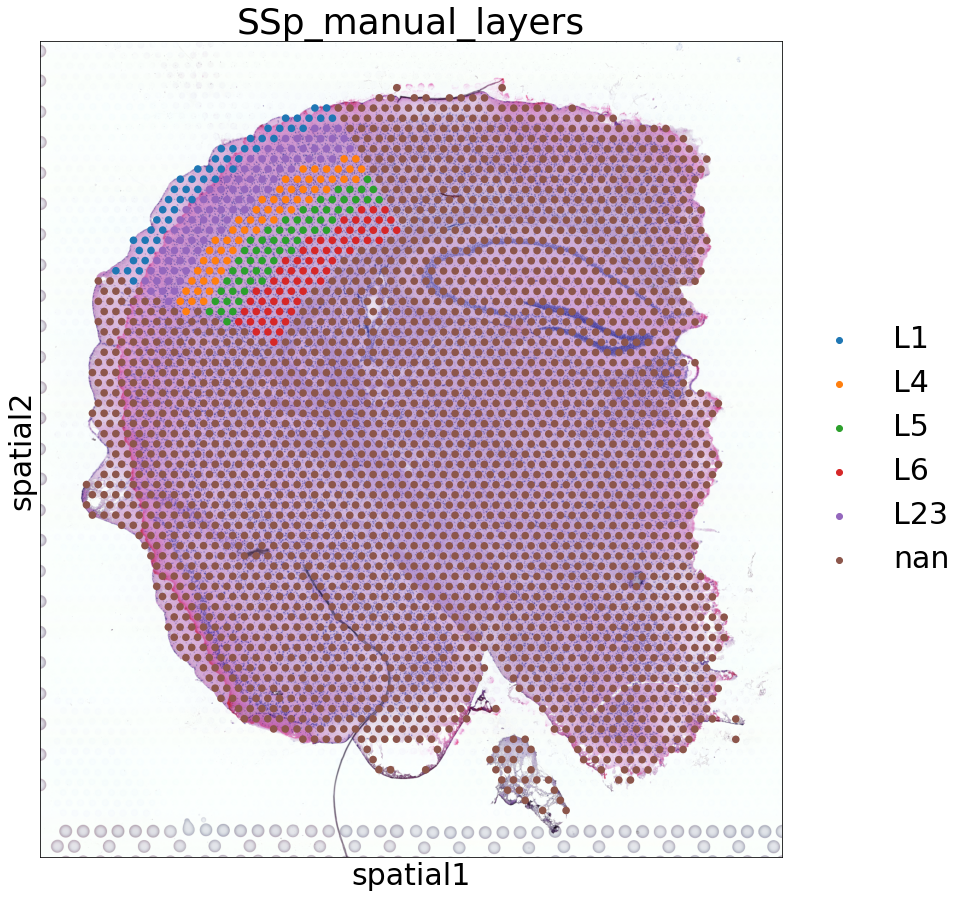

In [8]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_full.pdf')

In [9]:
adata.obs['sample'].value_counts()

ST8059049    3499
ST8059050    3497
ST8059048    2987
ST8059052    2576
ST8059051    2409
Name: sample, dtype: int64

In [10]:
# filter to cortical regions
ind = ~ adata.obs['SSp_manual_layers'].isna()
adata = adata[ind, :]

for i in slides.keys():
    ind = ~ (np.array(slides[i].obs['SSp_manual_layers'].isna()) \
             | np.array(slides[i].obs['SSp_manual_layers'].isin(['nan'])))
    slides[i] = slides[i][ind, :]

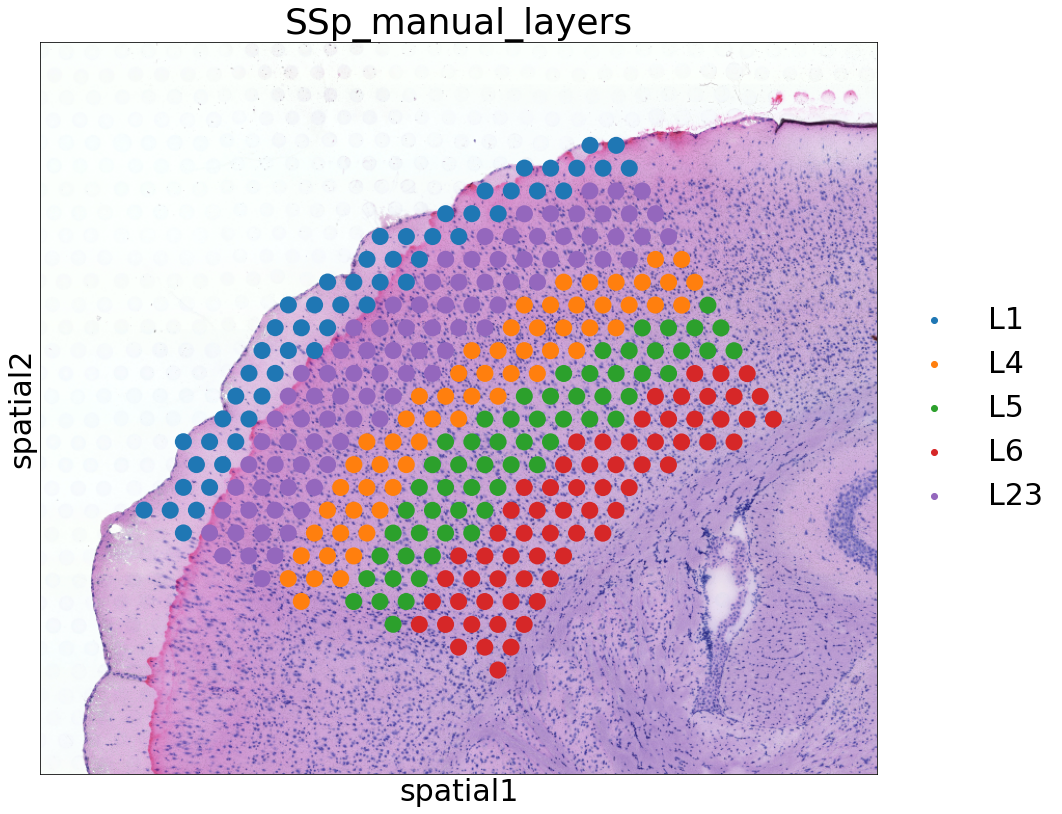

In [11]:
with matplotlib.rc_context({'axes.facecolor':  'white', 'figure.figsize': [15, 15], 'font.size': 30}):
    sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
                  color=['SSp_manual_layers'], size=1,
                  gene_symbols='SYMBOL', ncols=1,
                  save='Fig2I_layers_zoom.pdf')

Now let's look at QC: total number of counts and total number of genes per spot

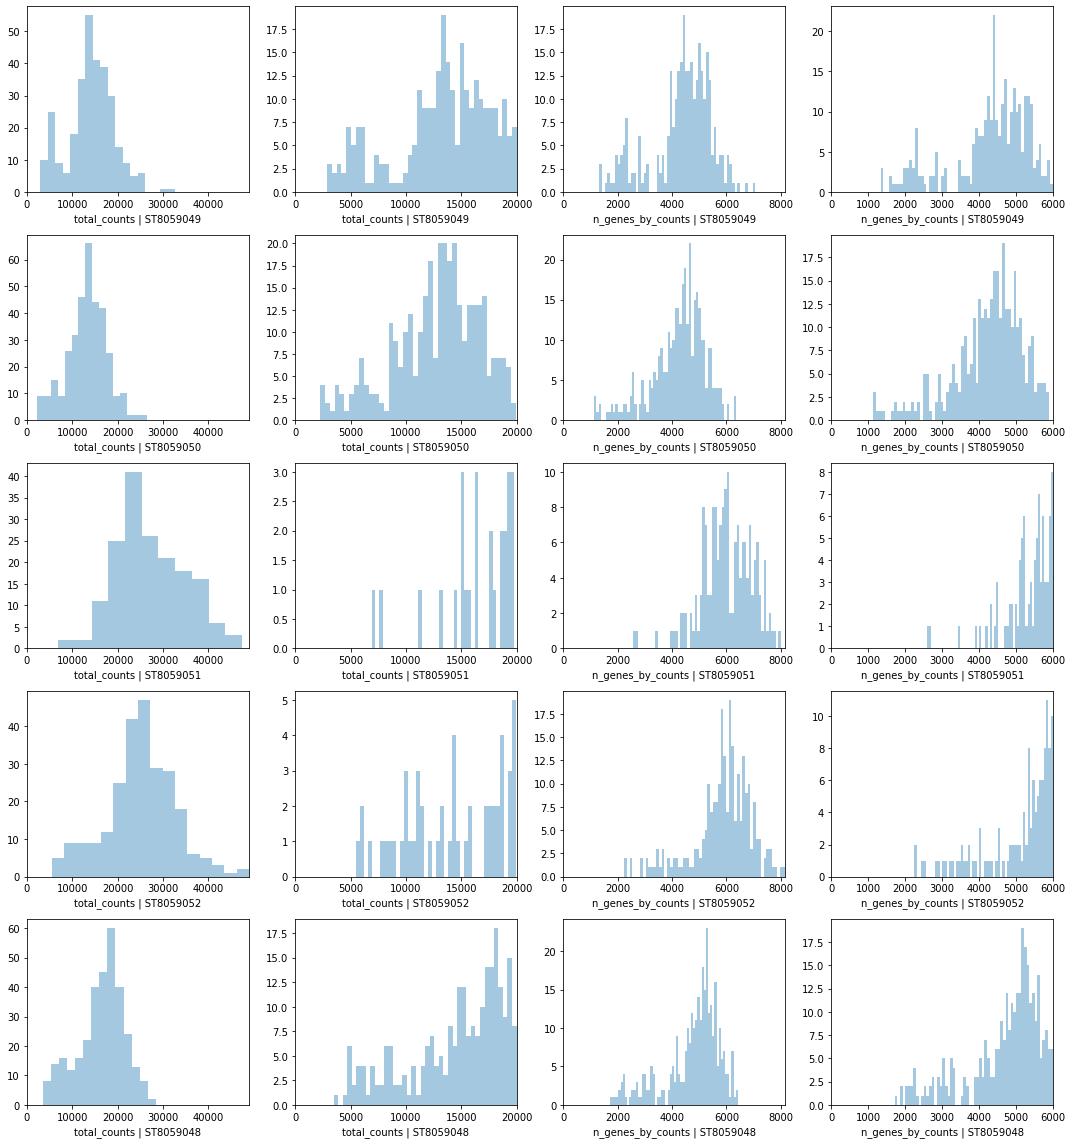

In [12]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

## Loading Allen single cell reference data <a class="anchor" id="read_allen"></a>

Mouse data:   
```bash
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/49/6e/496ea0c2-25ae-4523-bb84-8d51a63ab72e/readme_mouse.txt
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/sample-annotations.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/transcriptome.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/dendrogram.zip
cd /nfs/team205/vk7/sanger_projects/large_data/brains/mouse_allen/ && wget https://transcriptomic-viewer-downloads.s3-us-west-2.amazonaws.com/mouse/taxonomy.zip
```

```python
def extract_sparse_matrix(h5f, data_path):   
    r""" Read Allen data h5 file format into sparse matrix
    :param h5f: "h5f" is the handle that you get from "h5py.File('mouse/transcrip.tome')"
    :param data_path: "data_path" is the path within the archive.  In this case probably 
    either "/data/exon/" or "/data/intron/".
    """
    data = h5f[data_path]
    x = data['x']
    i = data['i']
    p = data['p']
    dims = data['dims']   
    
    sparse_matrix = ss.csc_matrix((x[0:x.len()], 
                                   i[0:i.len()], 
                                   p[0:p.len()]), 
                                  shape = (dims[0], dims[1]))    
    return sparse_matrix

# Open the file and import exon and intron data as sparse matrices
h5f = h5py.File(sc_data_folder + 'transcrip.tome')
exons = extract_sparse_matrix(h5f, '/data/exon/')
introns = extract_sparse_matrix(h5f, '/data/intron/')

# combine introns and exons
counts = introns + exons

# read cell and gene names
from re import sub
gene_names = pd.Series([sub("b\'|\'", '', str(i)) for i in np.array(h5f['gene_names'])])
sample_names = pd.Series([sub("b\'|\'", '', str(i)) for i in np.array(h5f['sample_names'])])

# read cell annotations
sample_meta = pd.DataFrame(np.array([[sub("b\'|\'", '', str(i)) for i in np.array(h5f['sample_meta']['anno'][i])] 
                                       for i in np.array(h5f['sample_meta']['anno'])]).T,
                           columns=np.array(h5f['sample_meta']['anno']),
                           index=sample_names)

# extract tSNE coordinates of cells
tsne = pd.DataFrame(np.array(h5f['projection']['tsne']))
tsne.index = [sub("b\'|\'", '', str(i)) for i in tsne['sample_name']]
tsne = tsne.reindex(index=sample_meta.index)
tsne = tsne[['x', 'y']].values

# create anndata object
adata_snrna_raw = anndata.AnnData(counts,obs=sample_meta)
adata_snrna_raw.var_names = gene_names
adata_snrna_raw.obsm['tsne'] = tsne

# remove cells with no TSNE coordinates
adata_snrna_raw = adata_snrna_raw[np.isnan(adata_snrna_raw.obsm['tsne']).sum(1) == 0,:]

# save all cells as h5ad
adata_snrna_raw.write(sc_data_folder + 'all.h5ad')
```

```python
adata_snrna_raw = anndata.read(sc_data_folder + 'all.h5ad')

# cells present in our sections
plus_v1 = ['AI', 'AUD', 'GU', 'HIP', 'RSP', 'SSp', 'SSs', 'SUB-ProS', 'TEa-PERI-ECT']
plus_v2 = ['AI', 'AUD', 'ENT1', 'GU', 'HIP', 'RSP', 'SSp', 'SSs', 'SUB-ProS', 'TEa-PERI-ECT', 'VIS']

# cells that should not be in our sections
minus = ['PAR-POST-PRE']

# filter to the region we need & save subsets
plus_v1_minus_ind = adata_snrna_raw.obs['region_label'].isin(plus_v1+minus)
plus_v1_ind = adata_snrna_raw.obs['region_label'].isin(plus_v1)
plus_v2_minus_ind = adata_snrna_raw.obs['region_label'].isin(plus_v2+minus)
plus_v2_ind = adata_snrna_raw.obs['region_label'].isin(plus_v2)
SSp_ind = adata_snrna_raw.obs['region_label'].isin(['SSp'])
HIP_ind = adata_snrna_raw.obs['region_label'].isin(['HIP'])

adata_snrna_raw[plus_v1_minus_ind,:].write(sc_data_folder + 'plus_v1_minus_visium.h5ad')
adata_snrna_raw[plus_v1_ind,:].write(sc_data_folder + 'plus_v1_visium.h5ad')
adata_snrna_raw[plus_v2_minus_ind,:].write(sc_data_folder + 'plus_v2_minus_visium.h5ad')
adata_snrna_raw[plus_v2_ind,:].write(sc_data_folder + 'plus_v2_visium.h5ad')
adata_snrna_raw[SSp_ind,:].write(sc_data_folder + 'SSp_visium.h5ad')
adata_snrna_raw[HIP_ind,:].write(sc_data_folder + 'HIP_visium.h5ad')
```

In [13]:
adata_snrna_raw = anndata.read(sc_data_folder + 'benchmark_SSp_PAR-POST-PRE.h5ad')
adata_snrna_raw.shape

(6948, 38377)

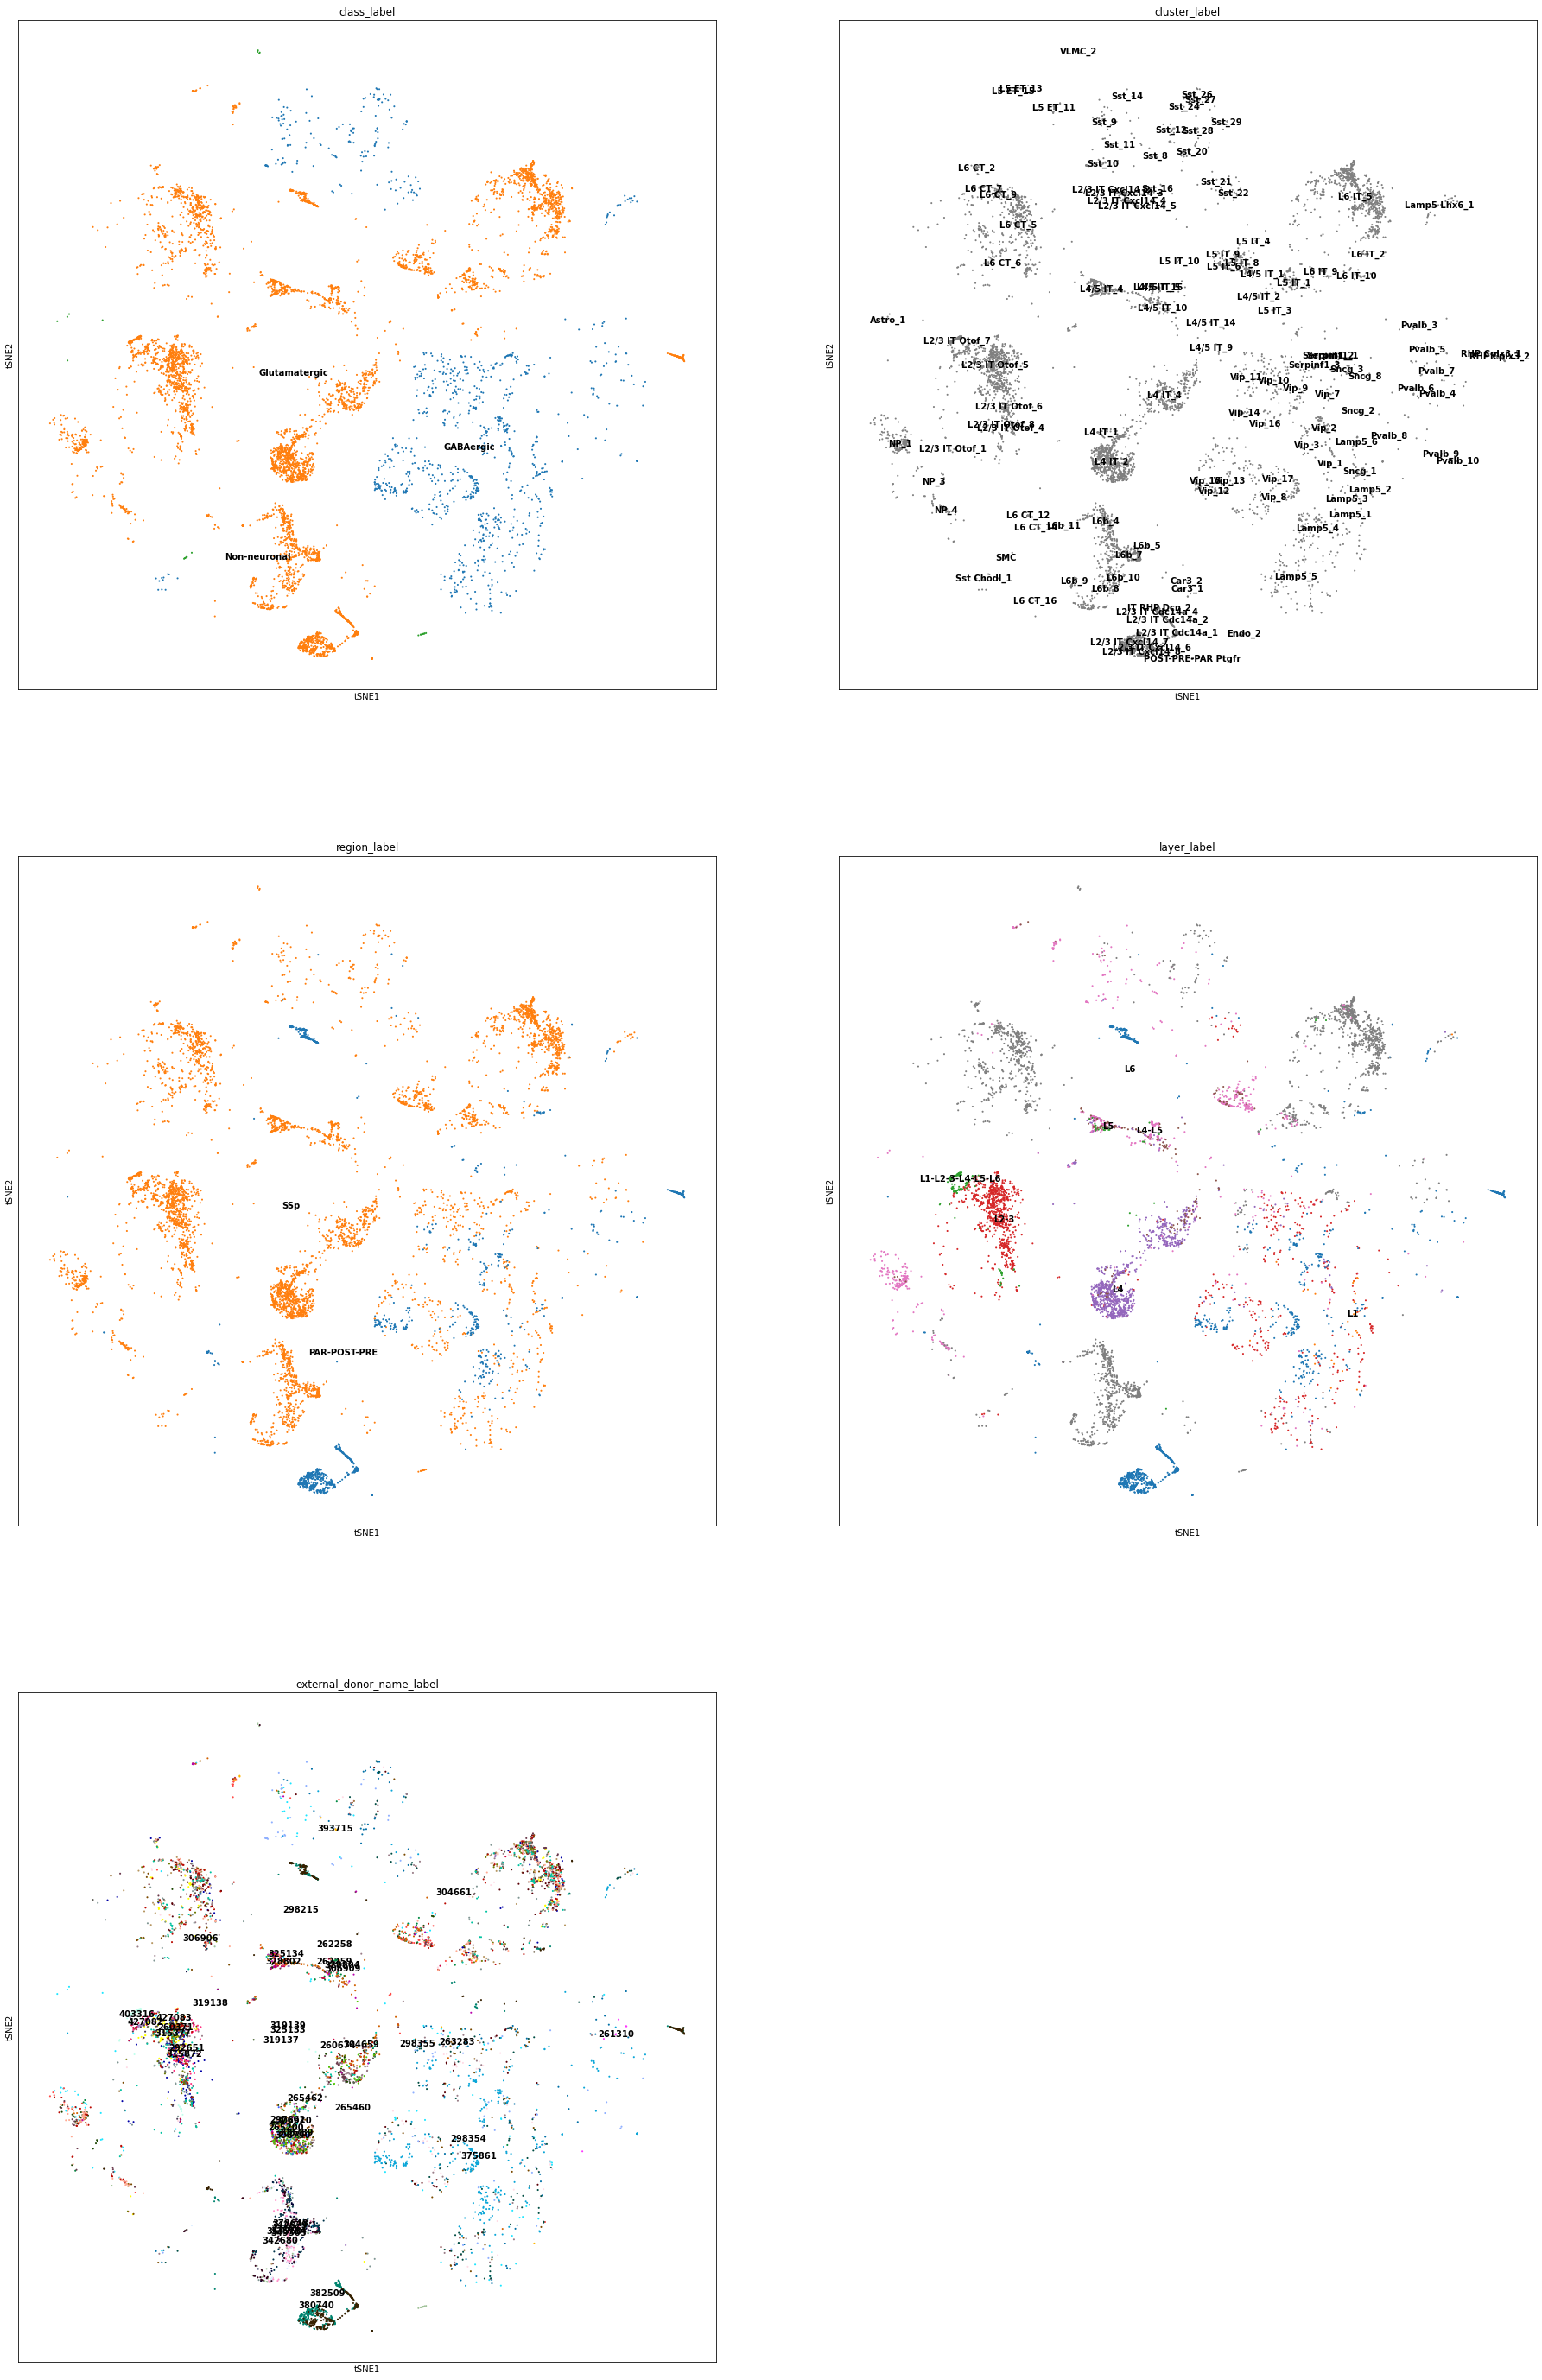

In [14]:
rcParams['figure.figsize'] = 15, 15
rcParams["axes.facecolor"] = "white"
sc.pl.tsne(adata_snrna_raw, color=['class_label', 'cluster_label', 'region_label', 
                                   'layer_label', 'external_donor_name_label'],
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=10)

Add counts matrix as `adata.raw` 

In [15]:
adata_vis = adata.copy()

sc.pp.filter_genes(adata_vis, min_cells=10)

adata_vis.var['ENSEMBL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['SYMBOL']
adata_vis.var = adata_vis.var.drop(columns=['SYMBOL'])

adata_vis.var_names_make_unique()

adata_vis

AnnData object with n_obs × n_vars = 1393 × 15459
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample_name', 'sample_name2', 'image_name', 'slide', 'position', 'SSp_manual_layers'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST8059050', 'mean_counts-ST8059050', 'log1p_mean_counts-ST8059050', 'pct_dropout_by_counts-ST8059050', 'total_counts-ST8059050', 'log1p_total_counts-ST8059050', 'n_c

In [16]:
#sc.pp.filter_genes(adata_snrna_raw, min_counts=1000)
ind = adata_vis.var_names.isin(adata_snrna_raw.var_names)
print(ind.sum())
ind = adata_vis.var_names[ind]

adata_snrna_raw = adata_snrna_raw[:, ind]
adata_snrna_raw.shape

13565


(6948, 13565)

In [17]:
adata_vis.raw = adata_vis
adata_snrna_raw.raw = adata_snrna_raw

### Run NNLS-autogenes <a class="anchor" id="NNLS-autogenes"></a>

gen	nevals	pareto	correlation      	distance                   
0  	100   	1     	5402.76 - 5402.76	321368295.68 - 321368295.68
1  	100   	1     	5402.76 - 5402.76	321368295.68 - 321368295.68


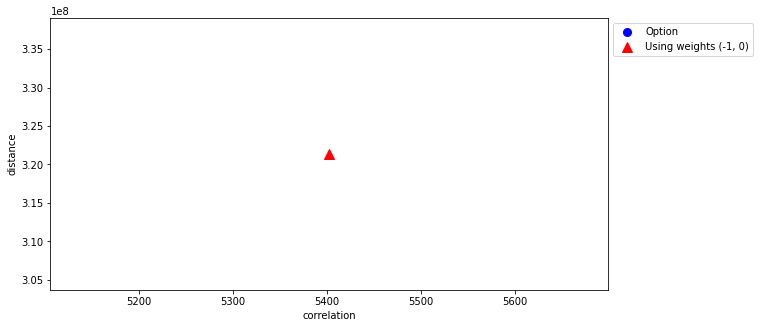

In [ ]:
import autogenes as ag

# Select all genes - just use the regression models
#adata_snrna_raw.var['selected'] = True

# Initialise autogenes object
#ag.init(adata_snrna_raw, genes_key='selected', celltype_key='annotation_1')

# choose genes shared between datasets
averages = cell2location.cluster_averages.get_cluster_averages(adata_snrna_raw, 'cluster_label')
ind = adata_vis.var_names[adata_vis.var_names.isin(averages.index)]
averages = averages.loc[ind, :]
ag.init(averages.T)
# do not run the gene selection
ag.optimize(ngen=1,nfeatures=averages.shape[0],seed=0, mode='fixed')
ag.plot(weights=(-1,0))

adata_vis_sel = anndata.AnnData(X=adata_vis.raw[:, adata_vis.raw.var_names.isin(averages.index)].X)
adata_vis_sel.var_names = adata_vis.raw.var_names[adata_vis.raw.var_names.isin(averages.index)]
adata_vis_sel.obs_names = adata_vis.raw.obs_names

# Deconvolve spatial data into single cell averages
start = time.time()
coef_nnls = ag.deconvolve(adata_vis_sel[:, averages.index].X.toarray(), #key='selected',
                          model='nnls')
print(str((time.time() - start) / 60) + ' min')

start = time.time()
coef_linear = ag.deconvolve(adata_vis_sel[:, averages.index].X.toarray(), #key='selected',
                            model='linear')
print(str((time.time() - start) / 60) + ' min')

#start = time.time()
#coef_nusvr = ag.deconvolve(adata_vis.raw.X.toarray(), #key='selected',
#                           model='nusvr')
#str((time.time() - start) / 60) + ' min'

# save results to DF
coef_nnls_df = pd.DataFrame(coef_nnls.T, columns=adata_vis.obs_names, index=averages.columns)
#coef_nusvr_df = pd.DataFrame(coef_nusvr, columns=adata_vis.obs_names, index=averages.columns)
coef_linear_df = pd.DataFrame(coef_linear.T, columns=adata_vis.obs_names, index=averages.columns)

# write to disc
coef_nnls_df.to_csv(results_folder + f'autogenes_models/coef_nnls_seed.csv')
#coef_nusvr_df.to_csv(results_folder + 'autogenes_models/coef_nusvr_seed.csv')
coef_linear_df.to_csv(results_folder + f'autogenes_models/coef_linear_seed.csv')

In [ ]:
coef_nnls_df.columns = [f'NNLS{i}' for i in coef_nnls_df.columns]
adata_vis.obs[coef_nnls_df.columns] = coef_nnls_df

#### Advanced plotting of cell locations

Here we visualise locations of multiple cell types at once.

In [ ]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata_vis[adata_vis.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

### Evaluate mapping accuracy by comparing to Allen <a class="anchor" id="mapping_accuracy"></a>

In [ ]:
# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='SSp_manual_layers', 
                       post_type='NNLS', 
                       summary_fun=np.mean, proportion_per_layer=False):
    
    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    from re import sub # create nice names
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[['L1', 'L23', 'L4', 'L5', 'L6']]
    infer_lay.columns = ['L1', 'L2-3', 'L4', 'L5', 'L6']
    infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

Using the data from all animals

In [ ]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['layer_label'].unique():
    ind = adata_snrna_raw.obs['layer_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
    
lay = lay[['L1', 'L2-3', 'L4', 'L5', 'L6']]
lay = lay.loc[lay.sum(1) > 0, :]
lay = lay.loc[np.sort(list(lay.index)), :]
lay = lay / lay.sum(0)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(25, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

Using the layer map in one section

In [ ]:
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059049 = layer_distribution(select_slide(adata_vis, 'ST8059049').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059051 = layer_distribution(select_slide(adata_vis, 'ST8059051').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059052 = layer_distribution(select_slide(adata_vis, 'ST8059052').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)

infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]
infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(infer_lay_ST8059048.T, figure_size=(25, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

### Fig S Negative controls

In [ ]:
# the distribution of cell types across regions
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
    

lay = lay / lay.sum(0)

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['PAR-POST-PRE'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_PAR_POST_PRE = lay.loc[(lay['SSp'] == 0) & (lay['PAR-POST-PRE'] > 0.0005), :]
lay_PAR_POST_PRE = lay_PAR_POST_PRE.loc[np.sort(list(lay_PAR_POST_PRE.index)), :]

# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['SSp'], bins=100);
plt.vlines(0.0015, 0, 20, color='black');
plt.show();

lay_SSp_stringent = lay.loc[(lay['SSp'] > 0.0015) & (lay['PAR-POST-PRE'] == 0), :]
lay_SSp = lay.loc[(lay['SSp'] > 0.0005), :]
lay_SSp = lay_SSp.loc[np.sort(list(lay_SSp.index)), :]


rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay_PAR_POST_PRE.T, figure_size=(8, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay_SSp.T, figure_size=(8, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

In [ ]:
lay_PAR_POST_PRE.shape

In [ ]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['region_label'].unique():
    ind = adata_snrna_raw.obs['region_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()
lay_binary_all = lay > 0
    
# reorder according to broad class
clearly_separated = [i for i in lay_SSp.index] + [i for i in lay_PAR_POST_PRE.index]
lay = lay.loc[clearly_separated, :]

#lay = lay.loc[lay.sum(1) > 15, :]
lay = lay / lay.sum(0)

lay_binary = lay > 0

rcParams["font.size"] = 3.9
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(8.3, 1.3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.0003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_reference.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig_path

In [ ]:
slide = adata_vis.copy() #select_slide(adata_vis, 'ST8059048').copy()

sel_clust = lay_binary.index.values
post_type = 'NNLS'
layer_col = 'sample'
sel_clust_col = [f'{post_type}{i}' for i in sel_clust]
infer_lay_df = slide.obs[sel_clust_col]
infer_lay_df.columns = sel_clust
#infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T

infer_lay = pd.DataFrame(index=sel_clust)
for r in slide.obs[layer_col].unique():
    ind = slide.obs[layer_col].isin([r])
    # sum / mean of cell density across all spots within a region
    infer_lay[r] = np.quantile(infer_lay_df.loc[ind, :], 0.995, axis=0)
    
gold_standard_lay = np.array([lay_binary['SSp'] for i in range(infer_lay.shape[1])]).T

infer_lay_nUMI = infer_lay.copy()

rcParams["font.size"] = 3.9
rcParams["axes.facecolor"] = "white"
clustermap(infer_lay.T, figure_size=(8.3, 1.6), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=40, vmax=10000
          )
plt.title('99.5% quantile mRNA count');
plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
plt.show()

In [ ]:
slide = adata_vis.copy() #select_slide(adata_vis, 'ST8059048').copy()

sel_clust = lay_binary.index.values
post_type = 'NNLS'
layer_col = 'sample'
sel_clust_col = [f'{post_type}{i}' for i in sel_clust]
infer_lay_df = slide.obs[sel_clust_col]
infer_lay_df.columns = sel_clust
#infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T

infer_lay = pd.DataFrame(index=sel_clust)
for r in slide.obs[layer_col].unique():
    ind = slide.obs[layer_col].isin([r])
    # sum / mean of cell density across all spots within a region
    infer_lay[r] = np.quantile(infer_lay_df.loc[ind, :], 0.995, axis=0)
    
gold_standard_lay = np.array([lay_binary['SSp'] for i in range(infer_lay.shape[1])]).T

infer_lay_cell_density = infer_lay.copy()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
clustermap(infer_lay.T, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.1, vmax=10
          )
plt.title('99.5% quantile cell density');
#plt.savefig(f'{fig_path}Fig2J_suppl_reference.pdf', bbox_inches='tight')
plt.show();

In [ ]:
infer_lay.shape

thresholds = {
 'ST8059048': 200, 
 'ST8059049': 200, 
 'ST8059050': 200, 
 'ST8059051': 300,
 'ST8059052': 300
}

matplotlib.rc_file_defaults()

sample_ids = adata_vis.obs['sample'].unique()
mapped_cell_types = []

fig, axs = plt.subplots(len(sample_ids), 1, figsize=(6, 6*len(sample_ids)-4))

for i, s in enumerate(sample_ids):
    
    ind = adata_vis.obs['sample'].isin([s])
    
    sc_cov = adata_vis.uns['mod']['post_sample_q05']['gene_factors'].sum(0)
    sp_weighted_cov = np.quantile(adata_vis.uns['mod']['post_sample_q05']['nUMI_factors'][ind,:], 0.995, axis=0)
    axs[i].scatter(sc_cov, sp_weighted_cov, s=2);
    axs[i].set_ylabel('Visium total UMI (99.5% quantile)');
    axs[i].set_title(s);
    
    axs[i].hlines(thresholds[s], 0, 2500000, color='black');
    mapped_cell_types_1 = adata_vis.uns['mod']['fact_names'][sp_weighted_cov > thresholds[s]]
    axs[i].set_xlabel(f"scRNA total UMI \n Mapped (>{thresholds[s]}): {mapped_cell_types_1}");
    mapped_cell_types = mapped_cell_types + list(mapped_cell_types_1)
    
plt.tight_layout()

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} (area = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.18), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.18),
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=3)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=3)
            
        
        lines.append(l)

        labels.append(method_title[i] + ' (area = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=14))

    #plt.show()
    return roc

with matplotlib.rc_context({"figure.figsize": (3, 3.2),
                            'pdf.fonttype': 42, "font.size": 8}):
    plot_precision_recall(gold_standard_lay, infer_lay_nUMI,
                          title='mRNA count',
                         save=f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping_prec_recall.pdf'
                         )
    plt.show()

### Fig 2J <a class="anchor" id="Fig2J"></a>

In [ ]:
lay = pd.DataFrame(index=adata_snrna_raw.obs['cluster_label'].unique())
for r in adata_snrna_raw.obs['layer_label'].unique():
    ind = adata_snrna_raw.obs['layer_label'].isin([r])
    lay[r] = adata_snrna_raw.obs.loc[ind, 'cluster_label'].value_counts()

lay = lay[['L1', 'L2-3', 'L4', 'L5', 'L6']]
lay[lay.isna()] = 0

lay_count = lay.copy()
lay_count = lay_count / lay_count.sum(0)

lay = lay.loc[lay_SSp_stringent.index]
lay = lay.loc[lay.sum(1) > 15, :]
lay = lay_count.loc[lay.index,:]
    
# reorder according to broad class
broad_class = adata_snrna_raw.obs[['class_label', 'cluster_label']].drop_duplicates()
broad_class.index = broad_class['cluster_label']
broad_class = broad_class.drop(columns='cluster_label')
broad_class = broad_class.sort_values(['class_label', 'cluster_label'], ascending=False)
index = list(broad_class.index[broad_class.index.isin(lay.index)])
lay = lay.loc[index, :]

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_suppl_reference.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
index_subset = list(broad_class[broad_class['class_label'].isin(['Glutamatergic'])].index)
index_subset = np.array(index_subset)[np.isin(index_subset, lay.index)]
lay_subset = lay.loc[index_subset,:].T
clustermap(lay_subset, 
           figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_reference.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
GABAergicindex_subset = list(broad_class[broad_class['class_label'].isin(['GABAergic'])].index)
GABAergicindex_subset = np.array(GABAergicindex_subset)[np.isin(GABAergicindex_subset, lay.index)]
lay_subset = lay.loc[GABAergicindex_subset,:].T
clustermap(lay_subset, 
           figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           #vmin=0.001, vmax=1
          )
plt.savefig(f'{fig_path}Fig2J_reference_GABAergic.pdf', bbox_inches='tight')
plt.show()

lay.shape

In [ ]:
lay.shape

Using the layer map in one section

In [ ]:
infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
infer_lay_ST8059048_sel = infer_lay_ST8059048.loc[lay.index,:]

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
infer_lay_ST8059048_sel = infer_lay_ST8059048_sel.loc[lay.index, :]
clustermap(infer_lay_ST8059048_sel.T, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_suppl_map.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
infer_lay_ST8059048_subset = infer_lay_ST8059048.loc[index_subset,:].T
clustermap(infer_lay_ST8059048_subset, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           vmin=0.003, vmax=1)
plt.savefig(f'{fig_path}Fig2J_map.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 10
rcParams["axes.facecolor"] = "white"
infer_lay_ST8059048_subset = infer_lay_ST8059048.loc[GABAergicindex_subset,:].T
clustermap(infer_lay_ST8059048_subset, figure_size=(10, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           #vmin=0.001, vmax=1
          )
plt.savefig(f'{fig_path}Fig2J_map_GABAergic.pdf', bbox_inches='tight')
plt.show()

In [ ]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
    
    plot_hist2d(lay, infer_lay_ST8059048, 
                'Allen data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
    plt.show()

In [ ]:
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index, :]
    
    
    index_subset = list(broad_class[broad_class['class_label'].isin(['Glutamatergic'])].index)
    index_subset = np.array(index_subset)[np.isin(index_subset, infer_lay_ST8059048.index)]
    infer_lay_ST8059048_subset = infer_lay_ST8059048.loc[index_subset,:].T
    lay_subset = lay.loc[index_subset,:].T
    
    plot_hist2d(lay_subset, infer_lay_ST8059048_subset, 
                'Allen data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/Allen_reference_vs_cell2location_Glutamatergic.pdf', bbox_inches='tight')
    
    plt.show()

### Fig 2J supplementary spatial maps <a class="anchor" id="suppl_spatial_maps"></a>

In [ ]:
from cell2location.plt.mapping_video import plot_spatial

# identify spot locations to crop near tissue
crop_max = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-0, crop_max[0]+30]
crop_y = [crop_max[1]+20, crop_min[1]-0]

sel_clust = ['L2/3 IT Otof_5', 'L4 IT_2', 'L4/5 IT_15', 'L5 IT_9', 'L6 IT_10']
sel_clust_col = ['NNLS' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,15)}):
    plot_spatial((slide.obs[sel_clust_col]), labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.85,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=20, alpha_scaling=0.7,
                  plt_axis='off', axis_y_flipped=False,
                  crop_x=crop_x, crop_y=crop_y)

In [ ]:
# identify spot locations to crop near tissue
crop_max = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (slides[s].obsm['spatial'] * list(slides[s].uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-0, crop_max[0]+30]
crop_y = [crop_max[1]+20, crop_min[1]-0]

sel_clust = ['L2/3 IT Otof_4', 'L4 IT_1', 'L4/5 IT_4', 'L6 CT_7', 'L6b_4']
sel_clust_col = ['NNLS' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,15)}):
    plot_spatial((slide.obs[sel_clust_col]), labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.85,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=20, alpha_scaling=0.7,
                  plt_axis='off', axis_y_flipped=False,
                  crop_x=crop_x, crop_y=crop_y)

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass